# HDL PRS example

Here we show an example of our pipeline for HDL PRS on UK Biobank samples. We use both effects estimates from MVP lipid traits analysis as well as posterior effects generated by `mashr` package.

## Data used

### Reference panel

Obtained via `download_1000G()` in `bigsnpr`. 

Including 503 (mostly unrelated) European individuals and ~1.7M SNPs in common with either HapMap3 or the UK Biobank. Classification of European population can be found at [IGSR](https://www.internationalgenome.org/category/population/). European individuals ID are from [IGSR data portal](https://www.internationalgenome.org/data-portal/sample).

### GWAS summary statistics data

From MVP. We have the original GWAS summary data as well as multivariate posterior estimate of HDL effects using [mashr](https://github.com/stephenslab/mashr). In brief, we have two versions of summary statistics (effect estimates) for HDL.

### Target test data: UK biobank

We select randomly from UK Biobank 2000 individuals with covariates and HDL phenotype (medication adjusted, inverse normalized). Their genotypes are extracted. See `UKB.QC.*` PLINK file bundle. 

### PRS Models

Auto model runs the algorithm for 30 different $p$ (the proportion of causal variants) values range from 10e-4 to 0.9, and heritability $h^2$ from LD score regression as initial value.

Grid model tries a grid of parameters $p$, ranges from 0 to 1 and three $h^2$ which are 0.7/1/1.4 times of initial $h^2$ estimated by LD score regression.

## Test genotype data preparation

Use `awk` select columns in phenotypes file saved to traits file `UKB.hdl.cov` and covariates file `UKB.ind.cov`.

In [ ]:
fam_UKB <- read.table("ukbiobank/UKB.fam", header = F, stringsAsFactors = F)
colnames(fam_UKB)=c("FID","IID","paternal.ID","maternal.ID","sex","affection")
covariates <- read.table("ukbiobank/UKBCauc_cholesterolandbloodpressurefields_inverseranknorm_covariatesage_sex_alcohol_smokingpackyears_foranalysis", header = T, stringsAsFactors = F)
suppressMessages(library(tidyverse))

set.seed(2021)
covariate = covariates %>%
    drop_na() %>%
    filter(FID %in% sample(FID,2000))
    
covariate = covariate[order(covariate[,1]),]

fam_UKB = fam_UKB %>% filter(FID %in% covariate$FID)
fam_UKB = fam_UKB[order(covariate[,1]),]
colnames(fam_UKB)<-NULL

write.table(covariate, file = "ukbiobank/UKB.cov", sep = " ", 
            row.names = F, col.names = T,)
write.table(fam_UKB, file = "ukbiobank/UKB.QC.fam", sep = " ", 
            row.names = FALSE, col.names = FALSE)

In [ ]:
cd ukbiobank
awk '{print $3, $4}' UKB.cov > UKB.ind.cov
awk '{print $14}' UKB.cov > UKB.hdl.cov
cd ..

We only want to focus on 2000 selected samples in UKB as target data. Below we extract this subset,

In [ ]:
sos run ldpred.ipynb snp_qc \
    --cwd ukbiobank \
    --genoFiles ukbiobank/UKB.bed \
    --keep-samples ukbiobank/UKB.QC.fam \
    --name 2000_subset

## Summary statistics data preparation

In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
format_data <- function(sums, chrpos, n_eff, prefix) {
  sums = inner_join(sums, chrpos, by = c("chr","pos")) %>% select(chr, pos, rsid, a0, a1, everything())
  
  print("inner join completed")
  
  sumstats_hdl  = sums %>% 
    select(chr, pos, rsid, a0,a1, hdl, hdl_se) %>% 
    rename(beta = hdl,
          beta_se = hdl_se) %>% 
    mutate(n_eff = n_eff)
  
  print("finish hdl")
  
  sumstats_ldl  = sums %>% 
   select(chr, pos, rsid, a0, a1, ldl, ldl_se) %>% 
    rename(beta = ldl,
          beta_se = ldl_se) %>% 
    mutate(n_eff = n_eff)
  
  print("finish ldl")

  sumstats_tc  = sums %>% 
    select(chr, pos, rsid, a0,a1, tc, tc_se) %>% 
    rename(beta = tc,
          beta_se = tc_se) %>% 
    mutate(n_eff = n_eff)
  
  print("finish tc")

  sumstats_tg  = sums %>% 
    select(chr, pos, rsid, a0,a1, tg, tg_se) %>% 
    rename(beta = tg,
          beta_se = tg_se) %>% 
    mutate(n_eff = n_eff)
  
  print("finish tg")
  
  print("data ready to save")
    saveRDS(sumstats_hdl, file = paste0(prefix, "_hdl.rds"))
    saveRDS(sumstats_ldl, file = paste0(prefix, "_ldl.rds"))
    saveRDS(sumstats_tc, file = paste0(prefix, "_tc.rds"))
    saveRDS(sumstats_tg, file = paste0(prefix, "_tg.rds"))  
}

In [5]:
chr_pos = bigreadr::fread2("mvpdata/chr_pos_allele2_lfsr.txt")
head(chr_pos)

chr_pos = chr_pos %>%
  extract(V1, into = c("chr", "pos"), regex = "([0-9]+)(\\:[0-9]+)") %>% 
  mutate(chr = as.numeric(chr),
         pos = as.numeric(str_replace(pos, ":",""))) %>% 
  rename(a0 = Allele1,
         a1 = Allele2,
         rsid = rsID) %>% 
  select(chr,pos,rsid,a0,a1)
head(chr_pos)

Warning message in data.table::fread(input, ..., data.table = data.table, nThread = nThread):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,V1,Allele1,Allele2,rsID,hdl,ldl,tg,tc
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:748332,T,C,rs182373484,0.5109300,0.3644157,0.5689165,0.3591687
2,1:751343,A,T,rs28544273,0.4295461,0.5213810,0.4557329,0.5505538
3,1:751756,T,C,rs143225517,0.4322768,0.5181581,0.4569321,0.5463038
4,1:752566,A,G,rs3094315,0.5774074,0.6145746,0.5934880,0.6117367
5,1:752721,A,G,rs3131972,0.5833319,0.5641637,0.5950461,0.5602104
6,1:753405,A,C,rs3115860,0.4092361,0.4824255,0.4297362,0.5109667


,chr,pos,rsid,a0,a1
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,748332,rs182373484,T,C
2,1,751343,rs28544273,A,T
3,1,751756,rs143225517,T,C
4,1,752566,rs3094315,A,G
5,1,752721,rs3131972,A,G
6,1,753405,rs3115860,A,C


In [6]:
raw_beta = readRDS("mvpdata/zmash_raw_univariate_MVP.rds")
raw_beta_se = bigreadr::fread2("mvpdata/Merged_MVP_Full_se_raw.txt")

Warning message in data.table::fread(input, ..., data.table = data.table, nThread = nThread):
“Detected 5 column names but the data has 6 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [7]:
raw_beta_se = raw_beta_se %>% 
  data.frame() %>% 
  rename(marker = m.Marker)
raw_beta = raw_beta %>% 
  data.frame() %>% 
  mutate(marker = rownames(raw_beta))

sumstats = inner_join(raw_beta_se,raw_beta, by = 'marker') %>% 
  select(marker, hdl,HDLSe,ldl,LDLSe, tg, TGSe, tc, TCSe)

colnames(sumstats) = c("marker", "hdl_z", "hdl_se", "ldl_z", "ldl_se", "tg_z", "tg_se", "tc_z", "tc_se")

sumstats = sumstats %>%
  extract(marker, into = c("chr", "pos"), regex = "([0-9]+)(\\:[0-9]+)") %>% 
  mutate(chr = as.numeric(chr),
         pos = as.numeric(str_replace(pos, ":","")))

In [8]:
# adjust the input GWAS summary stats to get bhat from z-scores
sumstats = sumstats %>% 
  mutate(hdl = hdl_z*hdl_se,
        ldl = ldl_z*ldl_se,
        tc = tc_z*tc_se,
        tg = tg_z*tg_se) %>% 
  select(-hdl_z,-ldl_z, -tc_z, -tg_z)

In [9]:
format_data(sumstats, chr_pos, 200000, "mvpdata/gwas")

[1] "inner join completed"
[1] "finish hdl"
[1] "finish ldl"
[1] "finish tc"
[1] "finish tg"
[1] "data ready to save"


In [10]:
pos_raw_beta = bigreadr::fread2("mvpdata/MVP_all_beta_posterior_beta.txt")
pos_raw_beta_se = bigreadr::fread2("mvpdata/posterior_beta_se.txt")

colnames(pos_raw_beta)=c("marker", "hdl","ldl","tg","tc")
colnames(pos_raw_beta_se)=c("marker", "hdl_se","ldl_se","tg_se","tc_se")

Warning message in data.table::fread(input, ..., data.table = data.table, nThread = nThread):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in data.table::fread(input, ..., data.table = data.table, nThread = nThread):
“Detected 4 column names but the data has 5 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [11]:
head(pos_raw_beta)

,marker,hdl,ldl,tg,tc
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:100000012,2.460009e-03,-0.0001055433,-0.0019129145,-0.0001208528
2,1:10000006,-6.929132e-05,0.0018424284,-0.0001815899,0.0014059207
3,1:100000507,-8.461508e-03,0.0171136365,0.0144205721,0.0179276152
4,1:100000827,3.042258e-03,0.0001911716,-0.0024015024,0.0001091159
5,1:100000843,-1.196533e-03,-0.0003462751,0.0011000920,-0.0002095452
6,1:100000948,1.142429e-02,0.0034483668,-0.0070852939,0.0034940914


In [12]:
head(pos_raw_beta_se)

,marker,hdl_se,ldl_se,tg_se,tc_se
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:100000012,0.002291870,0.001469390,0.001952622,0.001596889
2,1:10000006,0.014067514,0.011210222,0.014404394,0.012153967
3,1:100000507,0.027183021,0.028191475,0.029768057,0.029389961
4,1:100000827,0.002307946,0.001522781,0.002027389,0.001655077
5,1:100000843,0.002689326,0.002029852,0.002632001,0.002180022
6,1:100000948,0.014627076,0.010156359,0.012015341,0.010786769


In [13]:
pos_raw_beta_se = pos_raw_beta_se %>% 
  data.frame()
pos_raw_beta = pos_raw_beta %>% 
  data.frame()

In [14]:
sumstats_pos = inner_join(pos_raw_beta_se,pos_raw_beta, by = 'marker') %>% 
  select(marker, hdl,hdl_se,ldl,ldl_se, tg, tg_se, tc, tc_se)

head(sumstats_pos)

colnames(sumstats_pos) = c("marker", "hdl", "hdl_se", "ldl", "ldl_se", "tg", "tg_se", "tc", "tc_se")

sumstats_pos = sumstats_pos %>%
  extract(marker, into = c("chr", "pos"), regex = "([0-9]+)(\\:[0-9]+)") %>% 
  mutate(chr = as.numeric(chr),
         pos = as.numeric(str_replace(pos, ":","")))

,marker,hdl,hdl_se,ldl,ldl_se,tg,tg_se,tc,tc_se
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1:100000012,2.460009e-03,0.002291870,-0.0001055433,0.001469390,-0.0019129145,0.001952622,-0.0001208528,0.001596889
2,1:10000006,-6.929132e-05,0.014067514,0.0018424284,0.011210222,-0.0001815899,0.014404394,0.0014059207,0.012153967
3,1:100000507,-8.461508e-03,0.027183021,0.0171136365,0.028191475,0.0144205721,0.029768057,0.0179276152,0.029389961
4,1:100000827,3.042258e-03,0.002307946,0.0001911716,0.001522781,-0.0024015024,0.002027389,0.0001091159,0.001655077
5,1:100000843,-1.196533e-03,0.002689326,-0.0003462751,0.002029852,0.0011000920,0.002632001,-0.0002095452,0.002180022
6,1:100000948,1.142429e-02,0.014627076,0.0034483668,0.010156359,-0.0070852939,0.012015341,0.0034940914,0.010786769


In [15]:
format_data(sumstats_pos, chr_pos, 200000, "mvpdata/mash")

[1] "inner join completed"
[1] "finish hdl"
[1] "finish ldl"
[1] "finish tc"
[1] "finish tg"
[1] "data ready to save"


At this point files on the disk should be:

In [1]:
tree

.
├── 1000G.EUR
│   ├── 1000G.EUR.bed
│   ├── 1000G.EUR.bim
│   └── 1000G.EUR.fam
├── HDL_example.ipynb -> /home/gw/GIT/bioworkflows/ldpred/HDL_example.ipynb
├── ldpred.ipynb -> /home/gw/GIT/bioworkflows/ldpred/ldpred.ipynb
├── mvpdata
│   ├── chr_pos_allele2_lfsr.txt
│   ├── gwas_hdl.rds
│   ├── gwas_ldl.rds
│   ├── gwas_tc.rds
│   ├── gwas_tg.rds
│   ├── mash_hdl.rds
│   ├── mash_ldl.rds
│   ├── mash_tc.rds
│   ├── mash_tg.rds
│   ├── Merged_MVP_Full_se_raw.txt
│   ├── MVP_all_beta_posterior_beta.txt
│   ├── posterior_beta_se.txt
│   └── zmash_raw_univariate_MVP.rds
└── ukbiobank
    ├── UKB.2000_subset.bed
    ├── UKB.2000_subset.bim
    ├── UKB.2000_subset.fam
    ├── UKB.cov
    ├── UKB.hdl.cov
    ├── UKB.ind.cov
    └── UKB.QC.fam

3 directories, 25 files


## Analysis of MVP GWAS data

### Step 1: QC on reference panel

Here we assume the target data QC has been already performed. We perform here QC for reference panel,

In [1]:
work_dir=mvp_gwas

In [2]:
sos run ldpred.ipynb preprocess:1 \
    --cwd $work_dir \
    --genoFiles 1000G.EUR/1000G.EUR.bed

INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /home/gw/tmp/18-May-2021/mvp_gwas/1000G.EUR.mvp_gwas.bed
INFO: Workflow preprocess (ID=wa5ff477f2f89e365) is executed successfully with 1 completed step.


### Step 2: Intersect SNPs among summary stats, reference panel and target data

In [3]:
sos run ldpred.ipynb snp_intersect \
    --cwd $work_dir \
    --ss mvpdata/gwas_hdl.rds \
    --genoFiles $work_dir/1000G.EUR.$work_dir.bed ukbiobank/UKB.2000_subset.bed

INFO: Running snp_intersect_1: SNP intersect of summary stats and genotype data
INFO: snp_intersect_1 is completed.
INFO: snp_intersect_1 output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.intersect.rds /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.intersect.snplist
INFO: Running snp_intersect_2: 
INFO: snp_intersect_2 is completed (pending nested workflow).
INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: preprocess_1 (index=1) is completed.
INFO: preprocess_1 (index=0) is completed.
INFO: basic QC filters output:   /home/gw/tmp/18-May-2021/mvp_gwas/1000G.EUR.mvp_gwas.snp_intersect.extracted.bed /home/gw/tmp/18-May-2021/mvp_gwas/UKB.2000_subset.snp_intersect.extracted.bed in 2 groups
INFO: Running convert PLNIK to bigsnpr format with missing data mean imputed: 
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=0) is completed.
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=1) is completed.
INFO: convert PLNI

In [5]:
cat $work_dir/gwas_hdl.intersect.stdout

[1] "There are 405929 shared SNPs."


### Step 3: Harmonize alleles for shared SNPs

To handle major/minor allele, strand flips and consequently possible flips in sign for summary statistics.

In [6]:
sos run ldpred.ipynb snp_match \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss mvpdata/gwas_hdl.rds

INFO: Running snp_match: 
INFO: snp_match is completed.
INFO: snp_match output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.rds /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.snplist
INFO: Workflow snp_match (ID=w404833b15d6674fd) is executed successfully with 1 completed step.


### Step 4: Summary statistics quality control (optional)

We don't do this QC in the final version because it is difficult to get the scale correctly.

In [7]:
sos run ldpred.ipynb sumstats_qc \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss $work_dir/gwas_hdl.snp_matched.rds \
    --sdy 1

INFO: Running sumstats_qc: 
INFO: sumstats_qc is completed.
INFO: sumstats_qc output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.qc.png /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.qc.snplist... (3 items)
INFO: Workflow sumstats_qc (ID=w9504990385057ed9) is executed successfully with 1 completed step.


> mvp_gwas/gwas_hdl.snp_matched.qc.png (116.8 KiB):

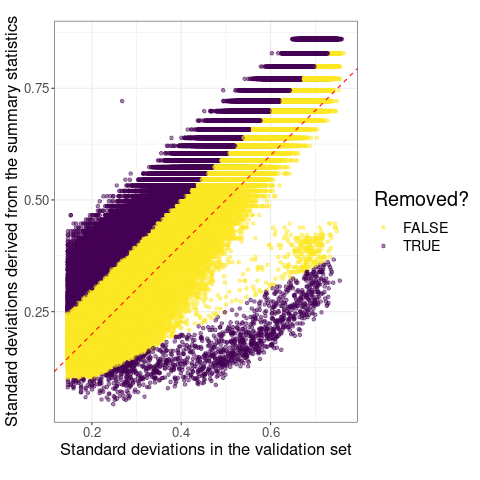

In [8]:
%preview mvp_gwas/gwas_hdl.snp_matched.qc.png

### Step 5: Calculate LD matrix and fit LDSC model

In [9]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.ld.rds
INFO: Workflow ldsc (ID=wc90eb2bded246504) is executed successfully with 1 completed step.


In [10]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.qc.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.qc.ld.rds
INFO: Workflow ldsc (ID=w2190d67bc69fd91b) is executed successfully with 1 completed step.


### Step 6: Estimate posterior effect sizes and PRS

For QC-ed data,

In [29]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.qc.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/gwas_hdl.snp_matched.qc.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.qc.inf_prs.rds
INFO: inf_prs output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.qc.inf_prs.rds
INFO: Workflow inf_prs (ID=wa62bc89ada0e2592) is executed successfully with 2 completed steps.


In [32]:
cat mvp_gwas/gwas_hdl.snp_matched.qc.inf_prs.stdout

[1] "232552 SNPs are used for PRS calculations"
[1] "232552 SNPs are used for PRS calculations"


In [ ]:
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.qc.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/gwas_hdl.snp_matched.qc.ld.rds

INFO: Running auto_prs: 
INFO: auto_prs is completed (pending nested workflow).
INFO: Running prs_core: 


In [ ]:
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.qc.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/gwas_hdl.snp_matched.qc.ld.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

For original data,

In [30]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/gwas_hdl.snp_matched.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.inf_prs.rds
INFO: inf_prs output:   /home/gw/tmp/18-May-2021/mvp_gwas/gwas_hdl.snp_matched.inf_prs.rds
INFO: Workflow inf_prs (ID=wa7cef8a5c314f787) is executed successfully with 2 completed steps.


In [31]:
cat mvp_gwas/gwas_hdl.snp_matched.inf_prs.stdout

[1] "384249 SNPs are used for PRS calculations"
[1] "384249 SNPs are used for PRS calculations"


In [ ]:
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/gwas_hdl.snp_matched.ld.rds

In [ ]:
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/gwas_hdl.snp_matched.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/gwas_hdl.snp_matched.ld.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

### Step 7: predict phenotypes

Baseline model: Traits ~ Sex + Age

In [4]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.baseline.rds
INFO: Workflow pred_eval (ID=w2415704657bde76b) is executed successfully with 1 completed step.


In [5]:
res = readRDS("mvp_gwas/UKB.hdl.baseline.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7973 -0.6148 -0.0072  0.5943  3.2185 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.083025   0.177526  -0.468   0.6401    
AGE          0.007225   0.003028   2.386   0.0171 *  
SEX         -0.857958   0.046395 -18.492   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9257 on 1597 degrees of freedom
Multiple R-squared:  0.177,	Adjusted R-squared:  0.176 
F-statistic: 171.7 on 2 and 1597 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model,0.17597,0.95412


Inf/grid/auto model: Traits ~ Sex + Age + PRS

In [38]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.qc.inf_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.inf_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval (index=0) is ignored due to saved signature
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.inf_prs.rds
INFO: Workflow pred_eval (ID=we0f848b067c83826) is ignored with 1 ignored step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.inf_prs.rds
INFO: Workflow pred_eval (ID=wbb35457749543c1e) is executed successfully with 1 completed step.


In [39]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9274 -0.5944  0.0028  0.5898  3.5610 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.515490   0.182145  -2.830  0.00471 ** 
AGE          0.006138   0.002972   2.065  0.03907 *  
SEX         -0.857887   0.045493 -18.858  < 2e-16 ***
PRS         -0.664444   0.082400  -8.064 1.44e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9076 on 1596 degrees of freedom
Multiple R-squared:  0.2092,	Adjusted R-squared:  0.2077 
F-statistic: 140.8 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.20773,0.91876


In [40]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9751 -0.5807 -0.0083  0.5798  3.7434 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.433701   0.173408  -2.501   0.0125 *  
AGE          0.006043   0.002913   2.074   0.0382 *  
SEX         -0.857926   0.044609 -19.232   <2e-16 ***
PRS         -0.787219   0.068654 -11.466   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.89 on 1596 degrees of freedom
Multiple R-squared:  0.2396,	Adjusted R-squared:  0.2382 
F-statistic: 167.7 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.23821,0.89215


In [41]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.qc.grid_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.grid_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.grid_prs.rds
INFO: Workflow pred_eval (ID=w572e9a7b247e7f40) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.grid_prs.rds
INFO: Workflow pred_eval (ID=w91862006b36b43f9) is executed successfully with 1 completed step.


In [42]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.grid_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9274 -0.6107 -0.0004  0.5825  3.7149 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.316030   0.172306  -1.834   0.0668 .  
AGE          0.006228   0.002919   2.134   0.0330 *  
SEX         -0.852849   0.044702 -19.079   <2e-16 ***
PRS         -0.802795   0.071950 -11.158   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8918 on 1596 degrees of freedom
Multiple R-squared:  0.2366,	Adjusted R-squared:  0.2351 
F-statistic: 164.8 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.grid_prs,0.23512,0.89653


In [43]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.grid_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0014 -0.5953 -0.0181  0.5609  3.8511 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.367020   0.169185  -2.169   0.0302 *  
AGE          0.006092   0.002865   2.126   0.0337 *  
SEX         -0.847968   0.043891 -19.320   <2e-16 ***
PRS         -1.046833   0.076154 -13.746   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8756 on 1596 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2627 
F-statistic: 190.9 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.grid_prs,0.26274,0.86741


In [44]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.qc.auto_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/gwas_hdl.snp_matched.auto_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.auto_prs.rds
INFO: Workflow pred_eval (ID=w9bf9aef80a3a5b7d) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.auto_prs.rds
INFO: Workflow pred_eval (ID=w099507f42af13c80) is executed successfully with 1 completed step.


In [45]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.qc.auto_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9925 -0.6067  0.0001  0.5854  3.5452 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.491939   0.180478  -2.726  0.00649 ** 
AGE          0.006317   0.002966   2.130  0.03336 *  
SEX         -0.853595   0.045421 -18.793  < 2e-16 ***
PRS         -1.333720   0.158835  -8.397  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9061 on 1596 degrees of freedom
Multiple R-squared:  0.2118,	Adjusted R-squared:  0.2103 
F-statistic:   143 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.auto_prs,0.21034,0.91589


In [46]:
res = readRDS("mvp_gwas/UKB.hdl.gwas_hdl.snp_matched.auto_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0331 -0.5738 -0.0088  0.5593  3.7989 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.405491   0.172225  -2.354   0.0187 *  
AGE          0.006289   0.002903   2.167   0.0304 *  
SEX         -0.851866   0.044459 -19.161   <2e-16 ***
PRS         -1.332495   0.111293 -11.973   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.887 on 1596 degrees of freedom
Multiple R-squared:  0.2448,	Adjusted R-squared:  0.2434 
F-statistic: 172.5 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.auto_prs,0.24341,0.88515


## Analysis of posterior from mashr analysis

In [47]:
work_dir=mvp_mashr

In [10]:
sos run ldpred.ipynb preprocess:1 \
    --cwd $work_dir \
    --genoFiles 1000G.EUR/1000G.EUR.bed

INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: basic QC filters is completed.
INFO: basic QC filters output:   /home/gw/tmp/18-May-2021/mvp_mashr/1000G.EUR.mvp_mashr.bed
INFO: Workflow preprocess (ID=wd4de15a1c376b706) is executed successfully with 1 completed step.


In [11]:
sos run ldpred.ipynb snp_intersect \
    --cwd $work_dir \
    --ss mvpdata/mash_hdl.rds \
    --genoFiles $work_dir/1000G.EUR.$work_dir.bed ukbiobank/UKB.2000_subset.bed

INFO: Running snp_intersect_1: SNP intersect of summary stats and genotype data
INFO: snp_intersect_1 is completed.
INFO: snp_intersect_1 output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.intersect.rds /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.intersect.snplist
INFO: Running snp_intersect_2: 
INFO: snp_intersect_2 is completed (pending nested workflow).
INFO: Running basic QC filters: Filter SNPs and select individuals
INFO: preprocess_1 (index=1) is completed.
INFO: preprocess_1 (index=0) is completed.
INFO: basic QC filters output:   /home/gw/tmp/18-May-2021/mvp_mashr/1000G.EUR.mvp_mashr.snp_intersect.extracted.bed /home/gw/tmp/18-May-2021/mvp_mashr/UKB.2000_subset.snp_intersect.extracted.bed in 2 groups
INFO: Running convert PLNIK to bigsnpr format with missing data mean imputed: 
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=0) is completed.
INFO: convert PLNIK to bigsnpr format with missing data mean imputed (index=1) is completed.
INFO: convert

In [23]:
cat $work_dir/mash_hdl.intersect.stdout

[1] "There are 405929 shared SNPs."


In [12]:
sos run ldpred.ipynb snp_match \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss mvpdata/mash_hdl.rds

INFO: Running snp_match: 
INFO: snp_match is completed.
INFO: snp_match output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.rds /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.snplist
INFO: Workflow snp_match (ID=w186d3bec3ba5cf62) is executed successfully with 1 completed step.


In [13]:
sos run ldpred.ipynb sumstats_qc \
    --cwd $work_dir \
    --reference_geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds \
    --ss $work_dir/mash_hdl.snp_matched.rds \
    --sdy 1

INFO: Running sumstats_qc: 
INFO: sumstats_qc is completed.
INFO: sumstats_qc output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.qc.png /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.qc.snplist... (3 items)
INFO: Workflow sumstats_qc (ID=w2c59f0ec0d937fed) is executed successfully with 1 completed step.


In [14]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.ld.rds
INFO: Workflow ldsc (ID=w7f1c19d96542ac2b) is executed successfully with 1 completed step.


In [15]:
sos run ldpred.ipynb ldsc \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.qc.rds \
    --reference-geno $work_dir/1000G.EUR.$work_dir.snp_intersect.extracted.rds

INFO: Running ldsc: 
INFO: ldsc is completed.
INFO: ldsc output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.qc.ld.rds
INFO: Workflow ldsc (ID=w9c10595de65ee7e6) is executed successfully with 1 completed step.


In [16]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.qc.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/mash_hdl.snp_matched.qc.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.qc.inf_prs.rds
INFO: inf_prs output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.qc.inf_prs.rds
INFO: Workflow inf_prs (ID=w45fd7fb3ebfcab9e) is executed successfully with 2 completed steps.


In [33]:
cat mvp_mashr/mash_hdl.snp_matched.qc.inf_prs.stdout

[1] "20823 SNPs are used for PRS calculations"


In [ ]:
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.qc.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/mash_hdl.snp_matched.qc.ld.rds

In [ ]:
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.qc.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/mash_hdl.snp_matched.qc.ld.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

In [17]:
sos run ldpred.ipynb inf_prs \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/mash_hdl.snp_matched.ld.rds

INFO: Running inf_prs: 
INFO: inf_prs is completed (pending nested workflow).
INFO: Running prs_core: 
INFO: prs_core is completed.
INFO: prs_core output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.inf_prs.rds
INFO: inf_prs output:   /home/gw/tmp/18-May-2021/mvp_mashr/mash_hdl.snp_matched.inf_prs.rds
INFO: Workflow inf_prs (ID=w4eb86481d9cc5dca) is executed successfully with 2 completed steps.


In [24]:
cat mvp_mashr/mash_hdl.snp_matched.inf_prs.stdout

[1] "384249 SNPs are used for PRS calculations"


In [ ]:
sos run ldpred.ipynb auto_prs \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/mash_hdl.snp_matched.ld.rds

In [ ]:
sos run ldpred.ipynb grid_prs \
    --cwd $work_dir \
    --ss $work_dir/mash_hdl.snp_matched.rds \
    --target-geno $work_dir/UKB.2000_subset.snp_intersect.extracted.rds \
    --ldsc $work_dir/mash_hdl.snp_matched.ld.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

In [48]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/mash_hdl.snp_matched.qc.inf_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/mash_hdl.snp_matched.inf_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval (index=0) is ignored due to saved signature
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_mashr/UKB.hdl.mash_hdl.snp_matched.qc.inf_prs.rds
INFO: Workflow pred_eval (ID=wd27629e69fa31b3d) is ignored with 1 ignored step.
INFO: Running pred_eval: 
INFO: pred_eval (index=0) is ignored due to saved signature
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_mashr/UKB.hdl.mash_hdl.snp_matched.inf_prs.rds
INFO: Workflow pred_eval (ID=wb763f8f4c756374e) is ignored with 1 ignored step.


In [49]:
res = readRDS("mvp_mashr/UKB.hdl.mash_hdl.snp_matched.qc.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8847 -0.6110 -0.0145  0.5794  3.6182 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.054782   0.171253   0.320   0.7491    
AGE          0.005945   0.002916   2.039   0.0417 *  
SEX         -0.855382   0.044644 -19.160   <2e-16 ***
PRS         -0.824114   0.072617 -11.349   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8907 on 1596 degrees of freedom
Multiple R-squared:  0.2385,	Adjusted R-squared:  0.237 
F-statistic: 166.6 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.23703,0.9015


In [50]:
res = readRDS("mvp_mashr/UKB.hdl.mash_hdl.snp_matched.inf_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9588 -0.5837 -0.0024  0.5558  3.8298 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.301697   0.166840  -1.808   0.0707 .  
AGE          0.006492   0.002835   2.290   0.0222 *  
SEX         -0.839408   0.043454 -19.317   <2e-16 ***
PRS         -2.620032   0.174296 -15.032   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8666 on 1596 degrees of freedom
Multiple R-squared:  0.2791,	Adjusted R-squared:  0.2777 
F-statistic: 205.9 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.inf_prs,0.27772,0.86121


In [51]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/mash_hdl.snp_matched.qc.grid_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/mash_hdl.snp_matched.grid_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_mashr/UKB.hdl.mash_hdl.snp_matched.qc.grid_prs.rds
INFO: Workflow pred_eval (ID=wd6a12f3f758471aa) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_mashr/UKB.hdl.mash_hdl.snp_matched.grid_prs.rds
INFO: Workflow pred_eval (ID=wf1950f2707475411) is executed successfully with 1 completed step.


In [54]:
res = readRDS("mvp_mashr/UKB.hdl.mash_hdl.snp_matched.qc.grid_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8728 -0.6088  0.0088  0.5600  3.7223 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.256292   0.171442   1.495   0.1351    
AGE          0.006371   0.002889   2.205   0.0276 *  
SEX         -0.852811   0.044254 -19.271   <2e-16 ***
PRS         -0.968053   0.076657 -12.628   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8829 on 1596 degrees of freedom
Multiple R-squared:  0.2518,	Adjusted R-squared:  0.2504 
F-statistic:   179 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.grid_prs,0.25036,0.89977


In [55]:
res = readRDS("mvp_mashr/UKB.hdl.mash_hdl.snp_matched.grid_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8588 -0.5948  0.0060  0.5638  3.7589 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.253032   0.165572  -1.528   0.1267    
AGE          0.006595   0.002819   2.340   0.0194 *  
SEX         -0.841308   0.043192 -19.478   <2e-16 ***
PRS         -1.565176   0.099437 -15.740   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8615 on 1596 degrees of freedom
Multiple R-squared:  0.2876,	Adjusted R-squared:  0.2863 
F-statistic: 214.8 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.grid_prs,0.28625,0.86267


In [52]:
sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/mash_hdl.snp_matched.qc.auto_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

sos run ldpred.ipynb pred_eval \
    --cwd $work_dir \
    --prs $work_dir/mash_hdl.snp_matched.auto_prs.rds \
    --phenoFile ukbiobank/UKB.hdl.cov \
    --covFile ukbiobank/UKB.ind.cov \
    --response continuous

INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_mashr/UKB.hdl.mash_hdl.snp_matched.qc.auto_prs.rds
INFO: Workflow pred_eval (ID=we633ac7b6501bb8d) is executed successfully with 1 completed step.
INFO: Running pred_eval: 
INFO: pred_eval is completed.
INFO: pred_eval output:   /home/gw/tmp/18-May-2021/mvp_mashr/UKB.hdl.mash_hdl.snp_matched.auto_prs.rds
INFO: Workflow pred_eval (ID=w46d07715baad0f37) is executed successfully with 1 completed step.


In [57]:
res = readRDS("mvp_mashr/UKB.hdl.mash_hdl.snp_matched.qc.auto_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9247 -0.6397  0.0132  0.5862  3.8274 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.177353   0.173464   1.022   0.3067    
AGE          0.005986   0.002931   2.042   0.0413 *  
SEX         -0.851004   0.044877 -18.963   <2e-16 ***
PRS         -0.631794   0.059903 -10.547   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8953 on 1596 degrees of freedom
Multiple R-squared:  0.2306,	Adjusted R-squared:  0.2292 
F-statistic: 159.5 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.auto_prs,0.22918,0.91379


In [58]:
res = readRDS("mvp_mashr/UKB.hdl.mash_hdl.snp_matched.auto_prs.rds")
summary(res$fitted)
res$summary


Call:
lm(formula = ., data = dat[train.ind, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8158 -0.6112  0.0151  0.5726  3.4785 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.183066   0.172628  -1.060    0.289    
AGE          0.007229   0.002940   2.459    0.014 *  
SEX         -0.849300   0.045047 -18.854   <2e-16 ***
PRS         -0.364799   0.036724  -9.933   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8986 on 1596 degrees of freedom
Multiple R-squared:  0.2249,	Adjusted R-squared:  0.2235 
F-statistic: 154.4 on 3 and 1596 DF,  p-value: < 2.2e-16


model,R2,MSE
<chr>,<dbl>,<dbl>
model.auto_prs,0.22346,0.92579


## Results summary

Following table shows adjusted R squared of HDL prediction model for original betas and posterior betas. QC is quality control in step 4.

Compared to baseline model, higher r-squared in ldpred model implies PRS explains part of the variation of HDL in train dataset (n=1600). 

Posterior betas have greater R squared compared to originial betas which implies PRS derived from posterior betas can explain much variance of HDL compared to PRS derived from original betas.

Among Inf, Grid and Auto, phynotype model with PRS derived using Grid model has the largest R squared which implies that Ldpred-grid model can find a hyper-parameter combination in prior distribution so that the PRS derived based on this prior distribution can explain much variance of HDL.

|   Betas   | QC? |   # of SNPs  |   Baseline  |   Inf   |   Grid  |   Auto |
|:---------:|:---:|:------------:|:-------:|:-------:|:-------:|:-------:|
|  Original | Yes | 232,552 | 0.176 | 0.20773 | 0.23512  | 0.21034 |
|  Original |  No | 384,249 | 0.176 | 0.23821 |    0.26274  |    0.24341   |
| Posterior | Yes | 20,823 | 0.176 |  0.23703 | 0.25036 | 0.22918 |
| Posterior |  No |  384,249  |  0.176  |  0.27772 |    0.28625    |    0.22346   |